In [1]:
import pandas as pd
import numpy as np
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display
import yfinance as yf
import dash
from dash import dcc
from dash import html
import matplotlib.pyplot as plt

## Importing the data

In [2]:
df_apex = pd.read_excel('apex_enterprise.xlsx', header=[0,1], index_col=0)

In [3]:
df_bloomberg = pd.read_excel('bloomberg.xlsx', header=[0,1], index_col=0)

## Showcasing the difference in ESG scores between the data from Apex Enterprise and Bloomberg

In [4]:
df_apex.index

Index(['A', 'AAL', 'AAP', 'AAPL', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADM',
       'AEE', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK', 'AMAT',
       'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANSS', 'AOS', 'APD', 'APH',
       'ARE', 'ATVI', 'AXP', 'BG', 'BMY', 'CDNS', 'CHRW', 'COF', 'CPB', 'GOOG',
       'LNT', 'MMM', 'MO'],
      dtype='object')

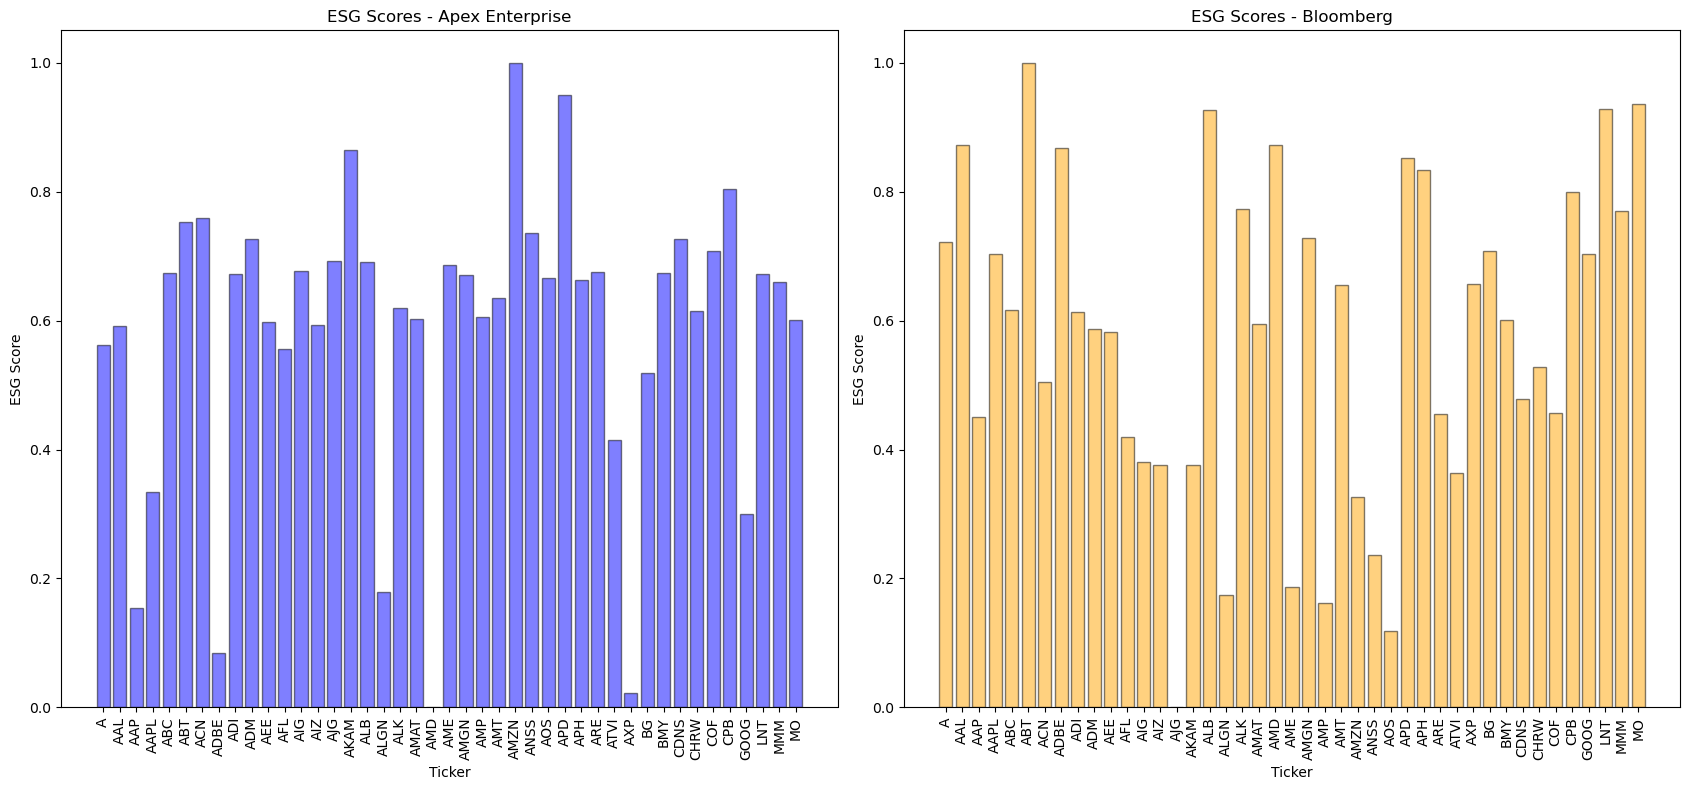

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 8))

# Apex histogram
ax1.bar(df_apex.index, df_apex['ESG']['ESG Score'], color='blue', alpha=0.5, edgecolor='black')
ax1.set_xlabel('Ticker')
ax1.set_ylabel('ESG Score')
ax1.set_title('ESG Scores - Apex Enterprise')
ax1.set_xticks(range(len(df_apex)))
ax1.set_xticklabels(df_apex.index, rotation='vertical')

# Bloomberg histogram
ax2.bar(df_bloomberg.index, df_bloomberg['ESG']['ESG Score'], color='orange', alpha=0.5, edgecolor='black')
ax2.set_xlabel('Ticker')
ax2.set_ylabel('ESG Score')
ax2.set_title('ESG Scores - Bloomberg')
ax2.set_xticks(range(len(df_bloomberg)))
ax2.set_xticklabels(df_bloomberg.index, rotation='vertical')

plt.tight_layout()
plt.show()

## Log returns

In [6]:
import log_return
log_re_apex = log_return.log_returns(df_apex['Adj Close'])
log_re_bloomberg = log_return.log_returns(df_bloomberg['Adj Close'])

In [7]:
from fetch_score import get_scores
esg_np_apex, e_np_apex, s_np_apex, g_np_apex = get_scores(df_apex)
esg_np_bloomberg, e_np_bloomberg, s_np_bloomberg, g_np_bloomberg = get_scores(df_bloomberg)

In [8]:
# Assuming your DataFrame is already defined as 'df'

# Convert index to datetime
log_re_apex.index = pd.to_datetime(log_re_apex.index)

# Create a line plot for each ticker
fig = go.Figure()

for column in log_re_apex.columns:
    fig.add_trace(go.Scatter(x=log_re_apex.index, y=log_re_apex[column], name=column, mode='lines'))

# Set the x-axis and y-axis labels and the plot title
fig.update_layout(
    title='Logarithmic Stock Returns',
    xaxis_title='Year',
    yaxis_title='Logarithmic Returns'
)

# Display the plot
fig.show()

## Covariance and inverse covariance matrix, and stocks mean return

In [9]:
from covariance import cov_matrix
from mean_ret import mean_return

In [10]:
cov_var_apex = cov_matrix(log_re_apex)
inv_cov_apex = np.linalg.inv(cov_var_apex)
mean_re_apex = mean_return(log_re_apex)

In [11]:
cov_var_bloomberg = cov_matrix(log_re_bloomberg)
inv_cov_bloomberg = np.linalg.inv(cov_var_bloomberg)
mean_re_bloomberg = mean_return(log_re_bloomberg)

## Finding two optimal portfolios with different expected return

In [12]:
from ones import vector_ones
from mvp import mvp_func
from weights_mvp import mvp_weights

In [13]:
vector_one_apex = vector_ones(df_apex)
a_apex, b_apex, c_apex, d_apex = mvp_func(inv_cov_apex, mean_re_apex, vector_one_apex)
w1_apex, w2_apex = mvp_weights(a_apex, b_apex, c_apex, d_apex, inv_cov_apex, vector_one_apex, mean_re_apex, 0.10, 0.26)

In [14]:
vector_one_bloomberg = vector_ones(df_bloomberg)
a_bloomberg, b_bloomberg, c_bloomberg, d_bloomberg = mvp_func(inv_cov_bloomberg, mean_re_bloomberg, vector_one_bloomberg)
w1_bloomberg, w2_bloomberg= mvp_weights(a_bloomberg, b_bloomberg, c_bloomberg, d_bloomberg, inv_cov_bloomberg, vector_one_bloomberg, mean_re_bloomberg, 0.10, 0.26)

## ESG insensitive investor

In [15]:
from alpha import alpha
from two_fun_theorem import w3

In [16]:
alpha_list = alpha([-3.5])
ef_weights_apex, r_apex, vol_apex, esg_wa_apex = w3(w1_apex, w2_apex, alpha_list, mean_re_apex, cov_var_apex, esg_np_apex)
ef_weights_bloomberg, r_bloomberg, vol_bloomberg, esg_wa_bloomberg = w3(w1_bloomberg, w2_bloomberg, alpha_list, mean_re_bloomberg, cov_var_bloomberg, esg_np_bloomberg)

In [17]:
tickers_list = []
labels = df_apex.index
for i in range(len(ef_weights_apex)):
    #assets = np.random.choice(list(labels), len(labels), replace=False)
    assets = list(labels)
    tickers_list.append(assets)
sr_t_list = list(labels)

## Global minimum variance portfolio

In [18]:
from global_mvp import global_mvp

In [19]:
mvp_weight_apex, mvp_er_apex, mvp_vol_apex, mvp_esg_score_apex, mvp_e_score_apex, mvp_s_score_apex, mvp_g_score_apex = global_mvp(ef_weights_apex, vol_apex, mean_re_apex, cov_var_apex, esg_np_apex, e_np_apex, s_np_apex, g_np_apex)
mvp_weight_bloomberg, mvp_er_bloomberg, mvp_vol_bloomberg, mvp_esg_score_bloomberg, mvp_e_score_bloomberg, mvp_s_score_bloomberg, mvp_g_score_bloomberg = global_mvp(ef_weights_bloomberg, vol_bloomberg, mean_re_bloomberg, cov_var_bloomberg, esg_np_bloomberg, e_np_bloomberg, s_np_bloomberg, g_np_bloomberg)

## ESG indicators

### For Apex ESG enterprise data-sample

In [20]:
from calculate_indicator import indicator

In [21]:
indicator(vector_one_apex, inv_cov_apex, mean_re_apex, r_apex, esg_np_apex, 0.79)

Variable outputs used from the paper
------------------------------------
Is delta 1 larger than zero: False
-------------------------------------
The value of delta 1 is: -0.1264129368477291
-------------------------------------
The value of Lambda 0 is: -1.7108994092967624

--------------------------------------
ESG score of the MVP is: 0.671203271704509
--------------------------------------


### For Bloomberg data-sample

In [22]:
indicator(vector_one_bloomberg, inv_cov_bloomberg, mean_re_bloomberg, r_bloomberg, esg_np_bloomberg, 0.79)

Variable outputs used from the paper
------------------------------------
Is delta 1 larger than zero: False
-------------------------------------
The value of delta 1 is: -0.8589987195438642
-------------------------------------
The value of Lambda 0 is: -12.762551842772615

--------------------------------------
ESG score of the MVP is: 0.6817837618655713
--------------------------------------


## ESG sensitive investor 

### Apex ESG Enterprise 

In [23]:
from esg_investor_weights import calculate_esg_sensitive_investor

In [24]:

list_target_returns = np.arange(r_apex.min(), r_apex.max(), 0.0016).tolist()
esg_investor_weights_apex, esg_portfolio_returns_apex, esg_portfolio_vol_apex, esg_investor_wa_apex  = calculate_esg_sensitive_investor(mean_re_apex, cov_var_apex, esg_np_apex, 0.79, list_target_returns, mvp_weight_apex)

In [25]:

list_target_returns = np.arange(r_bloomberg.min(), r_bloomberg.max(), 0.0016).tolist()
esg_investor_weights_bloomberg, esg_portfolio_returns_bloomberg, esg_portfolio_vol_bloomberg, esg_investor_wa_bloomberg  = calculate_esg_sensitive_investor(mean_re_bloomberg, cov_var_bloomberg, esg_np_bloomberg, 0.79, list_target_returns, mvp_weight_bloomberg)

## Optimal Sharpe ratio

### For Apex ESG Enterprise

In [26]:
from calculating_max_sr import calculate_max_sharpe_ratio
from calculating_max_ESG_sr import calculate_max_ESG_sharpe_ratio

In [27]:
sr_apex, w_opt_apex, sharpe_exp_apex, sharpe_vol_apex, sr_esg_score_apex, sr_e_score_apex, sr_s_score_apex, sr_g_score_apex = calculate_max_sharpe_ratio(0.03, mean_re_apex, cov_var_apex, esg_np_apex, e_np_apex, s_np_apex, g_np_apex, mvp_weight_apex, log_re_apex.columns.tolist())
sr_esg_apex, w_opt_esg_apex, sharpe_exp_esg_apex, sharpe_vol_esg_apex, sr_esg_esg_score_apex, sr_esg_e_score_apex, sr_esg_s_score_apex, sr_esg_g_score_apex = calculate_max_ESG_sharpe_ratio(0.03, mean_re_apex, cov_var_apex, esg_np_apex, e_np_apex, s_np_apex, g_np_apex, mvp_weight_apex, log_re_apex.columns.tolist(), 0.79)

## For Bloomberg

In [28]:
sr_bloomberg, w_opt_bloomberg, sharpe_exp_bloomberg, sharpe_vol_bloomberg, sr_esg_score_bloomberg, sr_e_score_bloomberg, sr_s_score_bloomberg, sr_g_score_bloomberg = calculate_max_sharpe_ratio(0.03, mean_re_bloomberg, cov_var_bloomberg, esg_np_bloomberg, e_np_bloomberg, s_np_bloomberg, g_np_bloomberg, mvp_weight_bloomberg, log_re_bloomberg.columns.tolist())
sr_esg_bloomberg, w_opt_esg_bloomberg, sharpe_exp_esg_bloomberg, sharpe_vol_esg_bloomberg, sr_esg_esg_score_bloomberg, sr_esg_e_score_bloomberg, sr_esg_s_score_bloomberg, sr_esg_g_score_bloomberg = calculate_max_ESG_sharpe_ratio(0.03, mean_re_bloomberg, cov_var_bloomberg, esg_np_bloomberg, e_np_bloomberg, s_np_bloomberg, g_np_bloomberg, mvp_weight_bloomberg, log_re_bloomberg.columns.tolist(), 0.79)

## Optimal Sortino Ratio

## For apex

In [29]:
from calculating_max_sortino import calculate_sortino_ratio
from calculate_max_ESG_sortino import calculate_ESG_sortino_ratio

optimal_weights_apex, optimal_sortino_ratio_apex, sortino_exp_apex, sortino_vol_apex, sortino_score_apex, sortino_e_score_apex, sortino_s_score_apex, sortino_g_score_apex = calculate_sortino_ratio(log_re_apex, 0.03, log_re_apex.columns.tolist(), mvp_weight_apex, mean_re_apex, cov_var_apex, esg_np_apex, e_np_apex, s_np_apex, g_np_apex)
optimal_weights_esg_apex, optimal_sortino_ratio_esg_apex, sortino_exp_esg_apex, sortino_vol_esg_apex, sortino_score_esg_apex, sortino_e_score_esg_apex, sortino_s_score_esg_apex, sortino_g_score_esg_apex = calculate_ESG_sortino_ratio(log_re_apex, 0.03, log_re_apex.columns.tolist(), mvp_weight_apex, mean_re_apex, cov_var_apex, esg_np_apex, e_np_apex, s_np_apex, g_np_apex, 0.79)

## For Bloomberg

In [30]:
optimal_weights_bloomberg, optimal_sortino_ratio_bloomberg, sortino_exp_bloomberg, sortino_vol_bloomberg, sortino_score_bloomberg, sortino_e_score_bloomberg, sortino_s_score_bloomberg, sortino_g_score_bloomberg = calculate_sortino_ratio(log_re_bloomberg, 0.03, log_re_bloomberg.columns.tolist(), mvp_weight_bloomberg, mean_re_bloomberg, cov_var_bloomberg, esg_np_bloomberg, e_np_bloomberg, s_np_bloomberg, g_np_bloomberg)
optimal_weights_esg_bloomberg, optimal_sortino_ratio_esg_bloomberg, sortino_exp_esg_bloomberg, sortino_vol_esg_bloomberg, sortino_score_esg_bloomberg, sortino_e_score_esg_bloomberg, sortino_s_score_esg_bloomberg, sortino_g_score_esg_bloomberg = calculate_ESG_sortino_ratio(log_re_bloomberg, 0.03, log_re_bloomberg.columns.tolist(), mvp_weight_bloomberg, mean_re_bloomberg, cov_var_bloomberg, esg_np_bloomberg, e_np_bloomberg, s_np_bloomberg, g_np_bloomberg, 0.79)

## Plotting the efficient frontiers

In [31]:
from plot_ef import ef_plot

## For Apex ESG Enterprise 

In [32]:
from plot_ef import ef_plot
plot = ef_plot(tickers_list, sr_t_list, 
               ef_weights_apex, vol_apex, r_apex, esg_wa_apex, 
               esg_investor_weights_apex, esg_portfolio_vol_apex, esg_portfolio_returns_apex, esg_investor_wa_apex, 
               w_opt_apex, sharpe_vol_apex, sharpe_exp_apex, sr_apex, sr_esg_score_apex,
               w_opt_esg_apex, sharpe_vol_esg_apex, sharpe_exp_esg_apex, sr_esg_apex, sr_esg_esg_score_apex,
               mvp_weight_apex, mvp_vol_apex, mvp_er_apex, mvp_esg_score_apex, 
               optimal_weights_apex, sortino_vol_apex, sortino_exp_apex, optimal_sortino_ratio_apex, sortino_score_apex, 
               optimal_weights_esg_apex, sortino_vol_esg_apex, sortino_exp_esg_apex, optimal_sortino_ratio_esg_apex, sortino_score_esg_apex,
               ratio='Sharpe Ratio')
plot.show()


## For Bloomberg

In [33]:
from plot_ef import ef_plot
plot = ef_plot(tickers_list, sr_t_list, 
               ef_weights_bloomberg, vol_bloomberg, r_bloomberg, esg_wa_bloomberg, 
               esg_investor_weights_bloomberg, esg_portfolio_vol_bloomberg, esg_portfolio_returns_bloomberg, esg_investor_wa_bloomberg, 
               w_opt_bloomberg, sharpe_vol_bloomberg, sharpe_exp_bloomberg, sr_bloomberg, sr_esg_score_bloomberg,
               w_opt_esg_bloomberg, sharpe_vol_esg_bloomberg, sharpe_exp_esg_bloomberg, sr_esg_bloomberg, sr_esg_esg_score_bloomberg,
               mvp_weight_bloomberg, mvp_vol_bloomberg, mvp_er_bloomberg, mvp_esg_score_bloomberg, 
               optimal_weights_bloomberg, sortino_vol_bloomberg, sortino_exp_bloomberg, optimal_sortino_ratio_bloomberg, sortino_score_bloomberg, 
               optimal_weights_esg_bloomberg, sortino_vol_esg_bloomberg, sortino_exp_esg_bloomberg, optimal_sortino_ratio_esg_bloomberg, sortino_score_esg_bloomberg,
               ratio='Sharpe Ratio')

plot.show()

## Portfolio performance

In [34]:
benchmark = pd.read_excel("sp500_bench.xlsx", header=[0], index_col=0)

In [35]:
from log_return import log_returns
log_market_returns = log_returns(benchmark)

## Apex ESG Enterprise 

In [36]:
from treynor import calculate_treynor
jensens_alpha_apex, beta_apex,timing_apex = calculate_treynor(12, log_re_apex, w_opt_esg_apex, log_market_returns, 0.03)

## Bloomberg

In [37]:
jensens_alpha_bloomberg, beta_bloomberg,timing_bloomberg = calculate_treynor(12, log_re_bloomberg, w_opt_esg_bloomberg, log_market_returns, 0.03)

## CVaR

In [38]:
daily_log_apex = log_returns(df_apex['Adj Close Daily'])
daily_log_bloomberg = log_returns(df_bloomberg['Adj Close Daily'])

In [39]:
demeand_log_daily_apex = daily_log_apex - daily_log_apex.mean(skipna=True)
demeand_log_daily_bloomberg = daily_log_bloomberg - daily_log_bloomberg.mean(skipna=True)

### CVaR for Apex ESG Enterprise

/Users/oscaraugustinus/Desktop/bachelor_function/calculate_CvaR.py:54: IntegrationWarning:

The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.



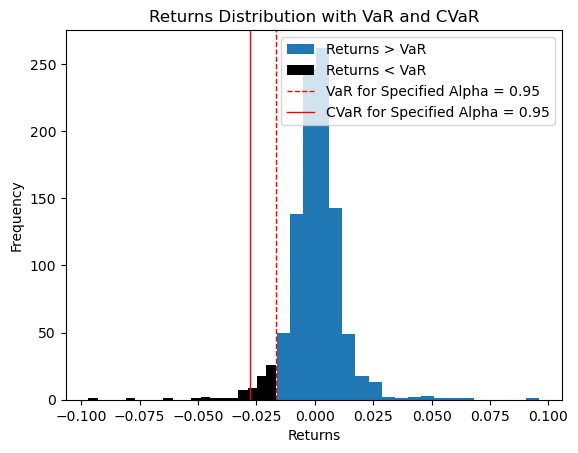

In [40]:
from calculate_CvaR import plot_var_cvar_histogram
VaR_apex, CVaR_apex, plot_apex = plot_var_cvar_histogram(demeand_log_daily_apex, w_opt_esg_apex, 0.95, 1000)
plot_apex.show()

### CVaR for Bloomberg

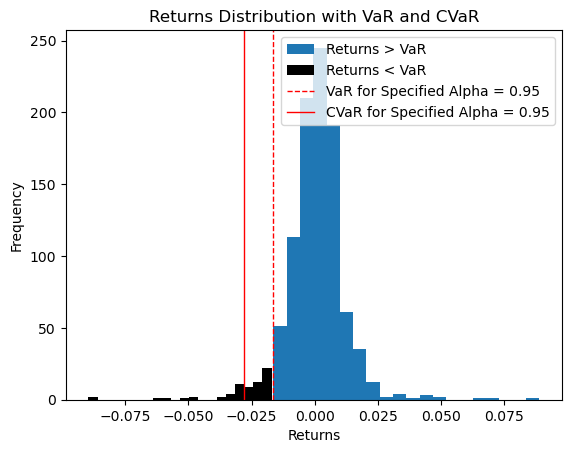

In [41]:
VaR_bloomberg, CVaR_bloomberg, plot_bloomberg = plot_var_cvar_histogram(demeand_log_daily_bloomberg, w_opt_esg_bloomberg, 0.95, 1000)